<a href="https://colab.research.google.com/github/BennoKrojer/CityClassifier/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = Path(root_dir + 'Colab Notebooks/fast.ai/')

Mounted at /content/gdrive


In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
from fastai.vision import *

In [0]:
path = Path(base_dir+'/CityClassifier/data')

In [0]:
path.ls()


[PosixPath('/content/gdrive/My Drive/Colab Notebooks/fast.ai/CityClassifier/data/models'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/fast.ai/CityClassifier/data/paris_url.csv'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/fast.ai/CityClassifier/data/rome_url.csv'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/fast.ai/CityClassifier/data/madrid_url.csv'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/fast.ai/CityClassifier/data/lisboa_url.csv'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/fast.ai/CityClassifier/data/london_url.csv'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/fast.ai/CityClassifier/data/berlin_url.csv'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/fast.ai/CityClassifier/data/moscow_url.csv'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/fast.ai/CityClassifier/data/paris'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/fast.ai/CityClassifier/data/london'),
 PosixPath('/content/gdrive/My Drive/C

## View data

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
# data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [0]:
data.classes

['berlin', 'lisboa', 'london', 'madrid', 'moscow', 'paris', 'rome']

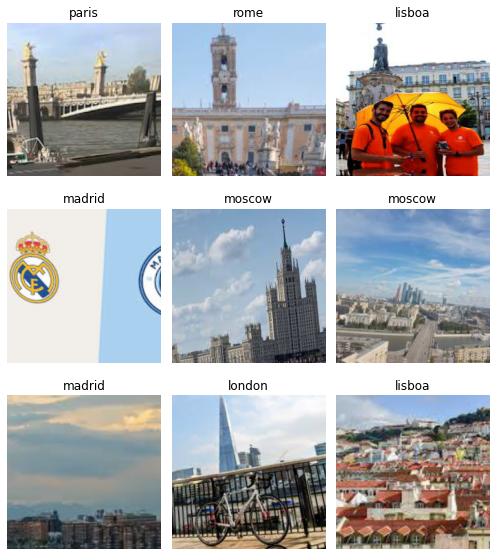

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['berlin', 'lisboa', 'london', 'madrid', 'moscow', 'paris', 'rome'],
 7,
 3129,
 782)

## Train model

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.fit_one_cycle(4)

In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


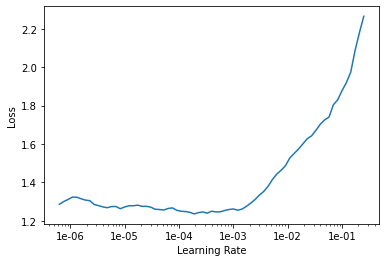

In [0]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8, max_lr=slice(3e-4,3e-3))

In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

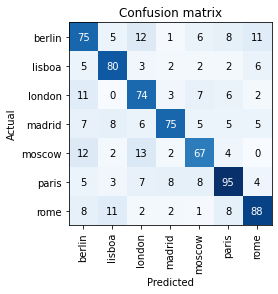

In [0]:
interp.plot_confusion_matrix()

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [0]:
from fastai.widgets import *

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [0]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

# db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
#                    .split_none()
#                    .label_from_df()
#                    .transform(get_transforms(), size=224)
#                    .databunch()
#      )

Then we create a new learner to use our new databunch with all the images.

In [0]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

Make sure you're running this notebook in Jupyter Notebook, not Jupyter Lab. That is accessible via [/tree](/tree), not [/lab](/lab). Running the `ImageCleaner` widget in Jupyter Lab is [not currently supported](https://github.com/fastai/fastai/issues/1539).

In [0]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())


If the code above does not show any GUI(contains images and buttons) rendered by widgets but only text output, that may caused by the configuration problem of ipywidgets. Try the solution in this [link](https://github.com/fastai/fastai/issues/1539#issuecomment-505999861) to solve it.


Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

Make sure to recreate the databunch and `learn_cln` from the `cleaned.csv` file. Otherwise the file would be overwritten from scratch, losing all the results from cleaning the data from toplosses.

In [0]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [0]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

In [0]:
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

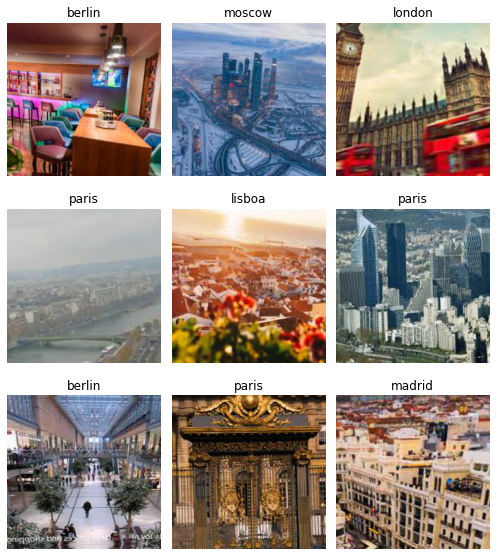

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['berlin', 'lisboa', 'london', 'madrid', 'moscow', 'paris', 'rome'],
 7,
 3066,
 766)

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [0]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [0]:
defaults.device = torch.device('cpu')

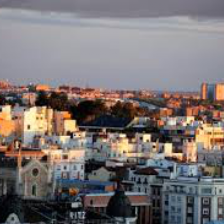

In [0]:
classes = data.classes
val_img = data.valid_ds[0][0]
groundtruth = data.valid_ds[0][1]
val_img

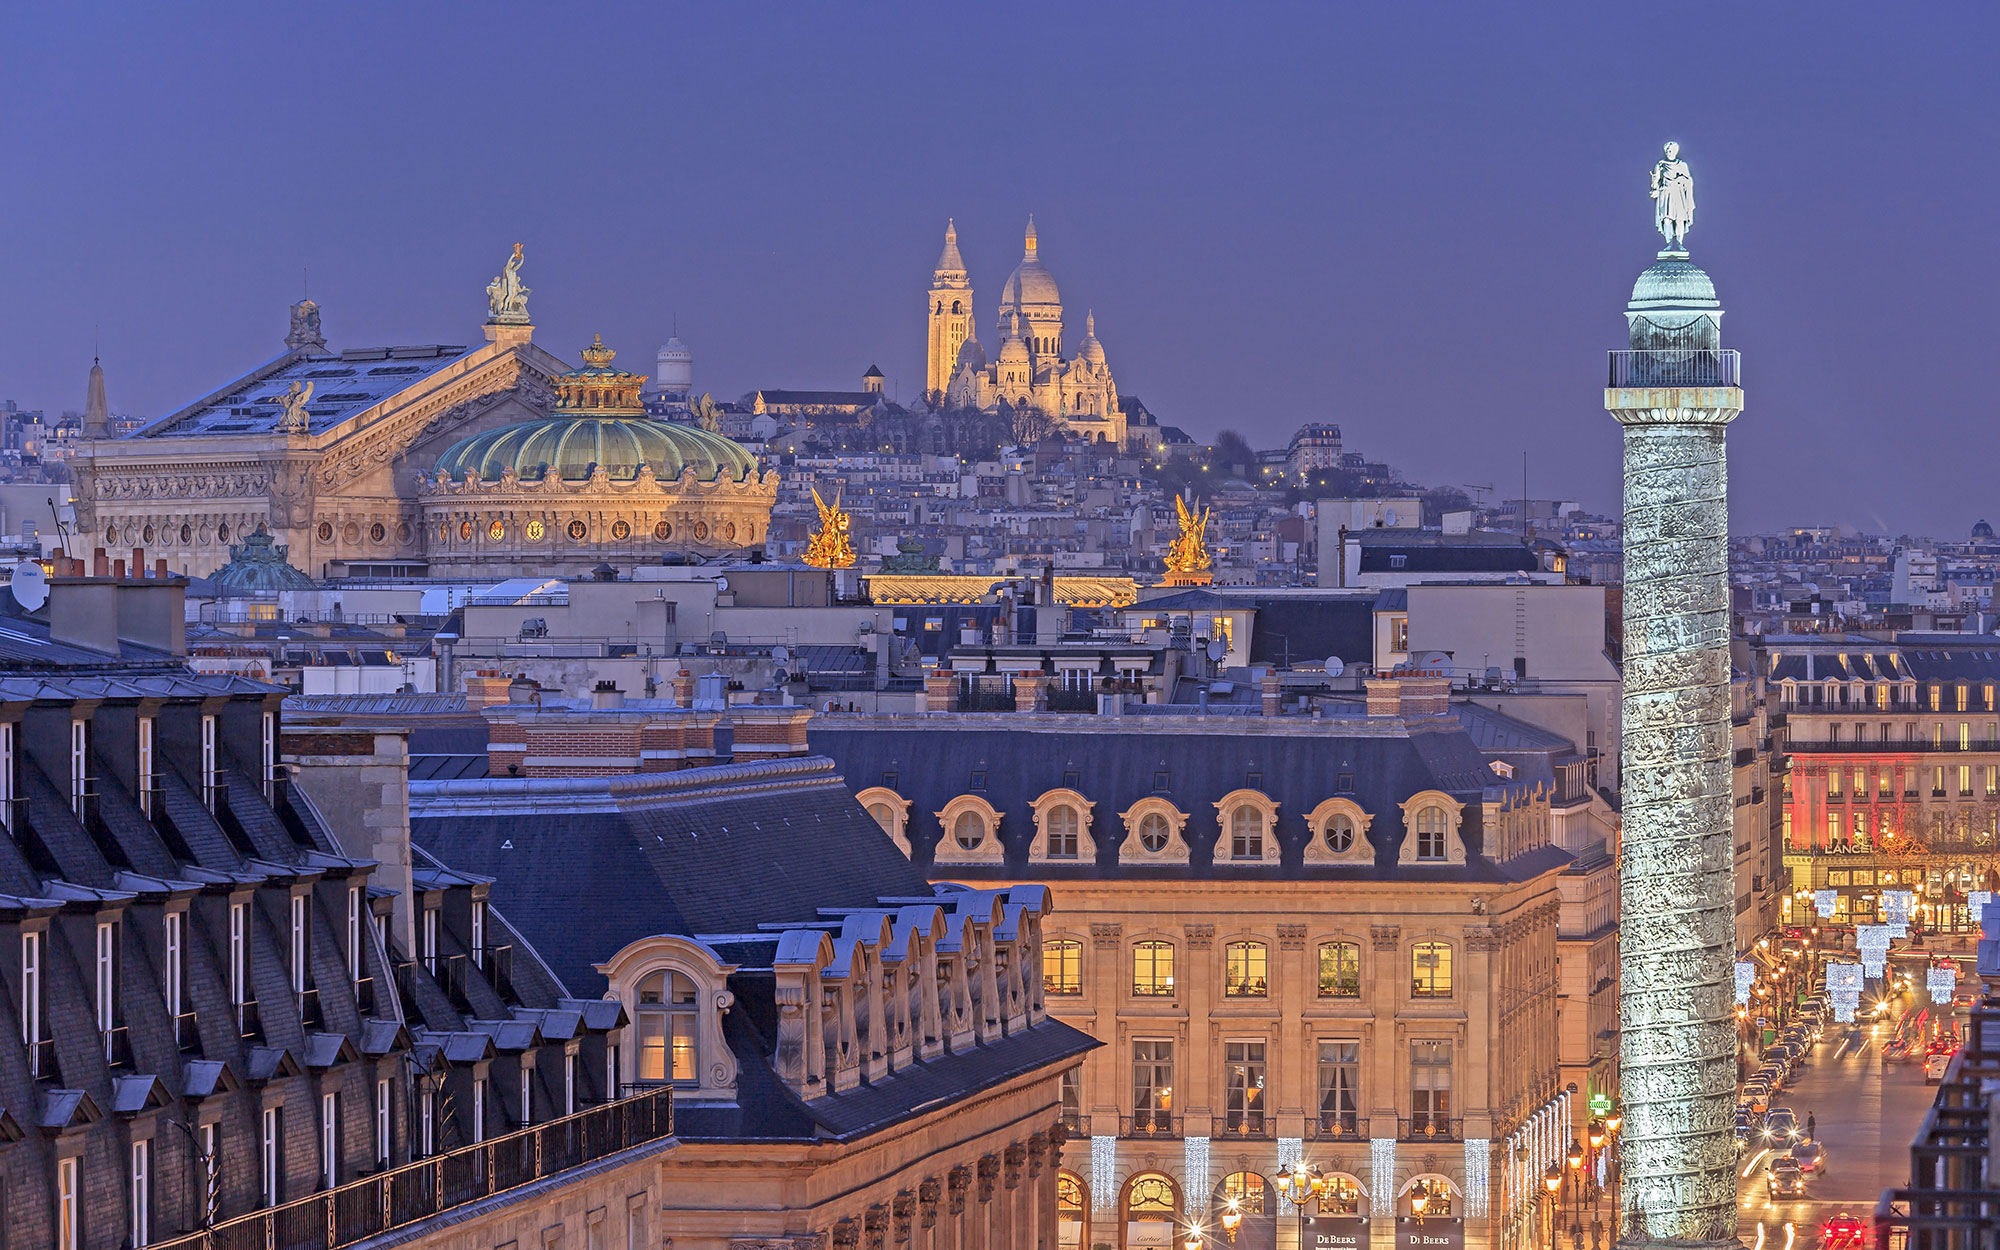

In [0]:
test_img = open_image(base_dir/'CityClassifier'/'data'/'test'/'paris.jpeg')
test_img

In [0]:
classes[int(groundtruth)]

'madrid'

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [0]:
learn = load_learner(path)

In [0]:
pred_class,pred_idx,outputs = learn.predict(test_img)
classes[int(pred_class)]

'paris'